# Práctico Clustering

El dataset de [GuessWhat?!](https://arxiv.org/abs/1611.08481) es un dataset de diálogos visuales referenciales.
Está compuesto de diálogos contextualizados en imágenes basados en un juego de adivinar un objeto. Todas las preguntas son del estilo "Sí/No".

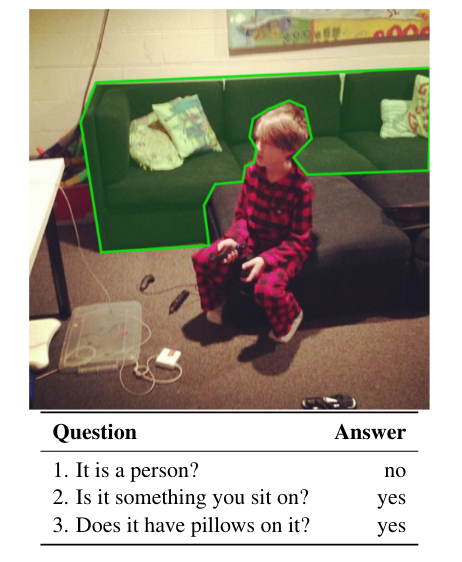

En este práctico voy a caracterizar las palabras usadas en distintas preguntas. El dataset se puede obtener [aquí](https://drive.google.com/file/d/1JiJIV_Ve65SHriU8veTtLVWmlM-Nu6pi/view?usp=sharing).

In [21]:
# Numpy
import numpy as np

# WordCloud
from wordcloud import WordCloud

# Sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# NLTK
from nltk.tokenize import TweetTokenizer

# PyPlot
import matplotlib.pyplot as plt

# Utils
import math
import jsonlines
import gzip
import os
import numpy as np
import json
from time import time
from tqdm import tqdm

In [8]:
rawdata = jsonlines.Reader(gzip.open('data/guesswhat.valid.jsonl.gz'))
questions = ""
for game in rawdata:
    for qa in game['qas']:
        questions += qa['question'].lower() + '\n'
        
fname = 'guesswhat.valid.raw.txt'
if not os.path.exists(fname):
    with open(fname, 'w') as fl:
        fl.write(questions)

## 2) Exploración Manual

Exploré antes un poco los datos para ver bien con qué estoy trabajando.

In [2]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')

print('Amount of questions: ', len(questions))

Amount of questions:  120319


In [3]:
questions = np.asarray(questions)
unique_questions = np.unique(questions)
print('Amount of unique questions: ', len(unique_questions))

Amount of unique questions:  52358


Miro la ocurrencia de palabras en el corpus original

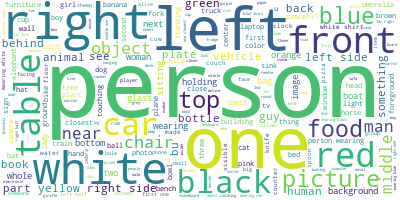

In [4]:
long_string = ','.join(questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

y en el corpus con solo preguntas únicas.

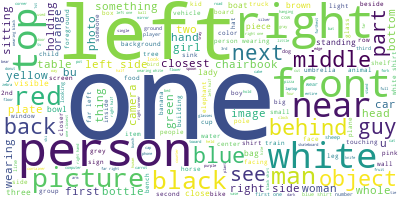

In [5]:
long_string = ','.join(unique_questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

## 3) Probar matriz de ocurrencia pelada

Se usa TweetTokenizer ya que ambos son user generated text.

In [23]:
tokenizer = TweetTokenizer()

In [24]:
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
omatrix = vectorizer.fit_transform(unique_questions)

In [25]:
print('Count Vectorizer: ----')
print(len(vectorizer.get_feature_names()))
print(omatrix.toarray().shape)

Count Vectorizer: ----
5232
(52358, 5232)


In [26]:
feat_matrix = omatrix.toarray()

In [29]:
start = time()
norm_feat_matrix = normalize(feat_matrix)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(norm_feat_matrix)
print('Elapsed: ', time() - start)

Elapsed:  34.51197290420532


In [30]:
np.save('features/feats-unique_qs-countvec-50d-1SVD_iter.npy', reduced_feat_matrix)

Clustering y gráfico

In [82]:
NCLUSTERS = 20

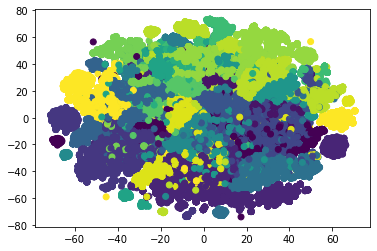

In [31]:
y_pred = KMeans(n_clusters=NCLUSTERS).fit_predict(reduced_feat_matrix)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)

Utils para visualización de clusters

In [40]:
q2cluster = {_idx: y_pred[_idx] for _idx in range(len(unique_questions))}
clusters_list = {_idx: [] for _idx in range(20)}

for idx, cluster in enumerate(y_pred):
    clusters_list[cluster].append(idx)
    
def showing_cluster(questions, q2cluster, clusters_list, cluster_id, showing=50, random=False):
    showing_qs = []
    cluster = clusters_list[cluster_id]
    if random:
        np.random.shuffle(cluster)
    
    for i in range(showing):
        qid = cluster[i]
        q_text = questions[qid]
        print(i, '-', q_text)

In [34]:
for i in range(NCLUSTERS):
    print('Cluster', i)
    showing_cluster(unique_questions, q2cluster, clusters_list, i)
    print('---------------')

Cluster 0
0 - 3rd one is the one on top, is that it?
1 - all of it?
2 - are any of the people touching it?
3 - are one of the 2 people in middle on it?
4 - are the scissors on top of it?
5 - are there 2 of it?
6 - are there four of it?
7 - are there several of it?
8 - are there two of it?
9 - back of it?
10 - both halves of it?
11 - does it cover part of the forehead?
12 - does it share the name of an animal?
13 - does it take up most of the picture?
14 - does one of the persons wear it?
15 - electronic or part of it?
16 - from the right side, there are 3 sheep facing left. is it one of those?
17 - from top to bottom, is it one of the first 7?
18 - from top to bottom, is it one of the top three?
19 - half of it bend?
20 - hello, is it one of the cars?
21 - hello, is it part of the computer?
22 - i can clearly see three cars on the right, is it one of them?
23 - i can see a woman's face and a tiny head at the bottom of the window...is it one of those?
24 - i can see three kids standing 

31 - a big object?
32 - a big one?
33 - a big p?
34 - a big piece?
35 - a bigger one?
36 - a bike ,?
37 - a bike ?
38 - a bike ??
39 - a bike?
40 - a bike??
41 - a bin?
42 - a bird?
43 - a bit darkish girl?
44 - a black bag?
45 - a black car seen its rear part?
46 - a black car?
47 - a black dairy?
48 - a black pan?
49 - a black pouch?
---------------
Cluster 12
0 - 1st one white black short right side?
1 - 2 row 5 white and black any of them?
2 - 3 row are here so 1st  row 2 white and black any of them?
3 - 3rd little guy with black face?
4 - 4th with black shirt?
5 - 6th black or bluish one?
6 - a black and gold one?
7 - a black long coat wearing lady?
8 - a black one ?
9 - a black one?
10 - a black shirt wearing ?
11 - a man in black?
12 - about as black rope?
13 - adult in black sweater?
14 - after black tee shirt person on left?
15 - all black attire?
16 - am i black?
17 - among the two black car?
18 - and black shirt?
19 - are they wearing black with a black hat?
20 - are those b

## 4) Usar embeddings

Para esta parte usamos word embeddings de GLoVE con 50 dimensiones. GuessWhat?! tiene una alta cantidad de palabras desconocidas, por lo que necesitamos un embedding para palabras desconocidas.

In [43]:
PRETRAINED_EMBS = "glove.6B.50d.txt.gz"

In [45]:
embeddings_dict = {}
with gzip.open(PRETRAINED_EMBS, "rt") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [47]:
UNK_EMB = np.random.rand(50)

In [74]:
def preprocess_data(corpus, embeddings_dict):
    new_data = []
    vocab = []
    skipped = []
    for i, entry in enumerate(corpus):
        words = entry.strip().split()
        if len(words) < 1:
            print('WARNING: skipped empty question')
            skipped.append(i)
            continue
        # remove the last ? sign
        last = words[-1]
        words = words[:-1] + [last[:-1], '?']
        # append tokens to vocabulary
        vocab += words
        # form new data
        sent_embs = [embeddings_dict[w] if w in embeddings_dict.keys() else UNK_EMB for w in words]
        new_entry = np.array(sent_embs).sum(axis=0)
        new_data.append(new_entry)
    return np.array(new_data), skipped

In [77]:
agg_embs_sents, skipped = preprocess_data(unique_questions, embeddings_dict)

In [87]:
NCLUSTERS=50

Elapsed:  549.1785001754761


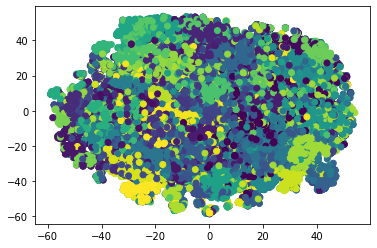

In [88]:
start = time()
norm_feat_matrix = normalize(agg_embs_sents)
y_pred = KMeans(n_clusters=NCLUSTERS).fit_predict(norm_feat_matrix)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(norm_feat_matrix)
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)
print('Elapsed: ', time() - start)

In [90]:
q2cluster = {_idx: y_pred[_idx] for _idx in range(len(unique_questions[1:]))}
clusters_list = {_idx: [] for _idx in range(NCLUSTERS)}

for idx, cluster in enumerate(y_pred):
    clusters_list[cluster].append(idx)

In [91]:
for i in range(NCLUSTERS):
    print('Cluster', i)
    showing_cluster(unique_questions[1:], q2cluster, clusters_list, i)
    print('---------------')

Cluster 0
0 - a person on the left sits on it?
1 - a person on the right side of the photo?
2 - above and right of that one?
3 - all the way at the right?
4 - all the way right by the cords?
5 - all the way to the right where there is just one boat?
6 - all the way to the right?
7 - am i on the right side of the boat?
8 - and is that something else on the left half of the photo?
9 - are the on the right side?
10 - are the toward the right side of the image?
11 - are they in the bottom right side of the picture?
12 - are they on the grass near the stands on the right?
13 - are they the guy at the very bottom of the right holding a book?
14 - ball in the right middle of the picture?
15 - behind the cat to the right on a shelf?
16 - bike ... close to that group of guys on the right side of the photo?
17 - bun which is from right side of us?
18 - but it is not standing on the rock edge on top right?
19 - but it is on the table?
20 - but it is still in the right half of the picture?
21 - ca

33 - am i looking for a real bird?
34 - am i multi colored?
35 - am i near the suitcase?
36 - am i near?
37 - am i on the boat?
38 - am i on the counter?
39 - am i on the floor?
40 - am i on the train?
41 - am i on the wall?
42 - am i ready to guess it?
43 - am i red?
44 - am i tall?
45 - am i white?
46 - anybody behind him?
47 - anything that touches the guy?
48 - apple one ??
49 - are they a guy?
---------------
Cluster 12
0 - all four legs?
1 - all knifes?
2 - all of cds?
3 - all of them together?
4 - all of them?
5 - all that sheets?
6 - all the people?
7 - among crowd?
8 - among the players .. ?
9 - among three males?
10 - among two darker ones on right?
11 - among two?
12 - and they are all either black, blue or gray?
13 - are all 4 holes visible?
14 - are all four legs visible?
15 - are both ears visible?
16 - are both feet touching ground?
17 - are both skis one object?
18 - are it clothes?
19 - are it shoes?
20 - are it's lights on?
21 - are its ears visible?
22 - are its horn

5 - a man who is near to us?
6 - about center?
7 - again the person closest to us?
8 - are they number 53 closest to us?
9 - at the very back, on top?
10 - back to us?
11 - back toward us?
12 - better to go from left?
13 - between that car and the next close car to us?
14 - big bottle near to us?
15 - brown /beige bear closest to us?
16 - brown leather, closest to us?
17 - car hiding in the bush ??
18 - chinese globe?
19 - close one?
20 - close to cam?
21 - close to camera?
22 - close to front?
23 - close to giraffe?
24 - close to its engine?
25 - close to middle?
26 - close to that row?
27 - close to the airplane?
28 - close to the brown one?
29 - close to the camera?
30 - close to the sink?
31 - close to the train?
32 - close to tv?
33 - close to us, not in the background?
34 - close to us?
35 - closer to camera?
36 - closer to him?
37 - closer to mountain?
38 - closer to the camera?
39 - closer to the plane?
40 - closer to the top?
41 - closer to us?
42 - closest on e?
43 - closest 

24 - blue sponge is it?
25 - bluish looking square shaped thing to left of rectangle?
26 - brown display?
27 - brown in color?
28 - by the thick greyish pole?
29 - chair color is white?
30 - color is green?
31 - color is red?
32 - color is white?
33 - colour brown?
34 - dark brown in color?
35 - dark in color?
36 - darker grey shirt, hand near mouth?
37 - decoration .?
38 - does appear mainly black in colour?
39 - does is have blue red sprinkles?
40 - does it contain a blue or green liquid?
41 - does it contain blue colour?
42 - does it contains blue color?
43 - does it contains green color?
44 - does it contains red color?
45 - does it has blue color?
46 - does it have a brownish colour?
47 - does it have a dark green color on it?
48 - does it have a light green color?
49 - does it have dark color?
---------------
Cluster 35
0 - ? on his head?
1 - a back man?
2 - a bench , ,?
3 - a blue grey-thing under his left arm, is that a thing?
4 - a chair , ,?
5 - a chair ,?
6 - a couch , ,?
7 

38 - 3  from bottom?
39 - 3 cars in picture?
40 - 3 from left?
41 - 3 row are here so 1st  row 2 white and black any of them?
42 - 3 zero shape?
43 - 4 from bottom?
44 - 4 the ??
45 - 4 the from top?
46 - 4 the?
47 - 5  from bottom?
48 - 5 in the air?
49 - 5 the?
---------------
Cluster 46
0 - 3 person with light clothe, are you agree?
1 - a can?
2 - all the broccoli?
3 - all the person that you can see?
4 - any cars maybe?
5 - anywhere around it?
6 - are u sure..leftmost person is not wearing eyeglasses?
7 - are u sure?
8 - are we getting closer ?
9 - are you able to see their head?
10 - are you being honest?
11 - are you going to answer yes to any question?
12 - are you going to quite on me?
13 - are you gonna work on it?
14 - are you in america?
15 - are you okay?
16 - are you smart?
17 - are you supposed to sit on it?
18 - are you sure it's a human being?
19 - are you sure it's not the cake server?
20 - are you sure it's not white?
21 - are you sure?
22 - are you there?
23 - are yo

- Cluster 0 posiciónes
- Cluster 1 parece vehicles
- Cluster 2 y 3 objetos
- Cluster 4 APDs?
- Cluster 5 color